## SVM

----

### 1. Import Modules

In [1]:
import numpy as np
import pandas as pd
import cimcb as cb
from sklearn.model_selection import train_test_split

print('All packages successfully loaded')

Using TensorFlow backend.


All packages successfully loaded


### 2. Load data and peak sheet

In [2]:
home = 'data/' 
file = 'GastricCancer_NMR.xlsx' 

DataTable,PeakTable = cb.utils.load_dataXL(home + file, DataSheet='Data', PeakSheet='Peak') 

Loadings PeakFile: Peak
Loadings DataFile: Data
Data Table & Peak Table is suitable.
TOTAL SAMPLES: 140 TOTAL PEAKS: 149
Done!


### 3. Extract X & Y

In [3]:
# Clean PeakTable
RSD = PeakTable['QC_RSD']   
PercMiss = PeakTable['Perc_missing']  
PeakTableClean = PeakTable[(RSD < 20) & (PercMiss < 10)]   

# Select subset of Data for the PLS-DA model
DataTable2 = DataTable[(DataTable.Class == "GC") | (DataTable.Class == "HE")]

# Create a Binary Y vector for stratifiying the samples
Outcomes = DataTable2['Class']                                  
Y = [1 if outcome == 'GC' else 0 for outcome in Outcomes]         
Y = np.array(Y)   

# Extract and scale the metabolite data from the DataTable
peaklist = PeakTable['Name']                           
XT = DataTable2[peaklist]                                    
XTlog = np.log(XT)                                          
XTscale = cb.utils.scale(XTlog, method='auto')              
XTknn = cb.utils.knnimpute(XTscale, k=3)  

### 4. Hyperparameters optimisation

In [5]:
# param_dict
# C_range = [2**-5, 2**-3, 2**-1, 2**1, 2**3, 2**5, 2**7, 2**9, 2**11, 2**13, 2**15]
# gamma_range = [2**-15, 2**-13, 2**-11, 2**-9, 2**-7, 2**-5, 2**-3, 2**-1, 2**1, 2**3]
C_range = [0.1, 1, 10, 100, 1000, 10000]
gamma_range = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01]

param_dict = dict(gamma=gamma_range, C=C_range)

# Initalise
cv = cb.cross_val.kfold(model=cb.model.SVM,                      
                                X=XTknn,                                 
                                Y=Y,                               
                                param_dict=param_dict,                   
                                folds=5,
                                n_mc=10)                                


# Initalise
cv = cb.cross_val.kfold(model=cb.model.SVM,                      
                                X=XTknn,                                 
                                Y=Y,                               
                                param_dict=param_dict,                   
                                folds=5,
                                n_mc=10)                                

# Run and plot
cv.run()  
cv.plot(metric='auc', ci=95, scale=1.3, color_beta=5) # color_scaling='tanh','tanh+1' , 'linear', 'sq', 'sqrt'

Number of cores set to: 8
Number of cores set to: 8
Running ...


100%|██████████| 360/360 [00:10<00:00, 35.59it/s]


Time taken: 0.17 minutes with 8 cores
Done!


Loading BokehJS ...

### 6. Get Model and Evaluate

In [6]:
# 6. Train, test and evaluate model

# Train model
model = cb.model.SVM(C=100, gamma=0.0001)
model.train(XTknn, Y)
model.test(XTknn)

# Evaluate 
model.evaluate(cutoffscore=0.5, plot_median=False) 

Loading BokehJS ...

In [8]:
# Bootstrap evaluate

model.booteval(XTknn, Y, errorbar=False, bootnum=100) #errorbar=True, cutoffscore=0.5, specificity=0.8

100%|██████████| 100/100 [00:01<00:00, 51.98it/s]


Loading BokehJS ...

### 7. Save table

In [9]:
home = 'tables/'
file = 'SVM_GastricCancer_NH.xlsx'

model.save_table(home + file)

Done! Saved table as tables/SVM_GastricCancer_NH.xlsx


In [10]:
import numpy as np
from sklearn import metrics

# Check booteval auc directly from plot (tpr, fpr)

# get fpr, tpr
fpr_ib = model.fpr_ib
fpr_oob = model.fpr_oob
tpr_ib = model.tpr_ib
tpr_oob = model.tpr_oob

# get auc using sklearn
auc_ib_scipy = metrics.auc(fpr_ib, tpr_ib)
auc_oob_scipy = metrics.auc(fpr_oob, tpr_oob)

# get auc using numpy (trapezoidal rule)
auc_ib_np = np.trapz(tpr_ib, fpr_ib)
auc_oob_np = np.trapz(tpr_oob, fpr_oob)

# print
print("auc_ib_scipy = {}".format(auc_ib_scipy))
print("auc_ib_numpy = {}".format(auc_ib_np))
print("auc_oob_scipy = {}".format(auc_oob_scipy))
print("auc_oob_numpy = {}".format(auc_oob_np))

auc_ib_scipy = 0.9999999999999999
auc_ib_numpy = 0.9999999999999999
auc_oob_scipy = 0.9258226937643002
auc_oob_numpy = 0.9258226937643002


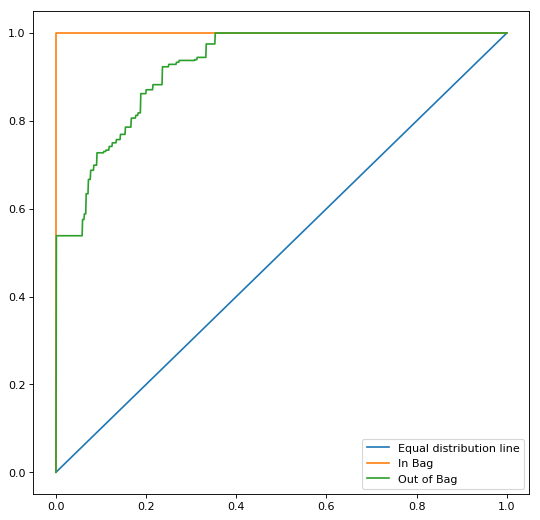

In [11]:
import matplotlib.pyplot as plt
% matplotlib inline

# Plot booteval tpr, fpr in matplotlib

plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(fpr_ib, fpr_ib)
plt.plot(fpr_ib, tpr_ib)
plt.plot(fpr_oob, tpr_oob)

plt.legend(['Equal distribution line', 'In Bag', 'Out of Bag'], loc='lower right')

plt.show()